In [1]:
import torch
import torch.nn.functional as F
import heapq
import torchtext
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 4)

import time
import random

from device import dev
from path import Path, Log_Path
from dataset import dataset
from model import RNN
from preprocess import get_transitions, add_transitions

from util import get_matrices
from util import blank_filling, identical_filling, empirical_filling, weighted_filling, near_filling,uniform_filling
from util import none_regularization, linear_regularization, strong_linear_regularization

from synonym import get_synonym

from evaluation import evaluation

if __name__ == '__main__':

    # select the dataset. options: 'news', 'toxic'
    DATASET = 'news'

    # select the clusters number
    CLUSTER = 40

    # select the completion and regularization tactics
    COMPLETION = [weighted_filling]
    REGULARIZATION = [linear_regularization]

    # select the iteration times of using synonym to augmenting dataset
    NUM_EPOCHS = 2
    REPLACE_RATE = 0.4
    DROPOUT = 0.2

    start_time = time.time()
    # load model and dataset
    train_dataset = dataset(DATASET, True)
    test_dataset = dataset(DATASET, False)
    model = torch.load(Path+DATASET+'_model.pth')
    model.eval()
    vocab_num = len(train_dataset.vocab)
    state_num = CLUSTER + 1
    print(f'vocab: {vocab_num}')
    print(f'data number: {len(train_dataset.int_data)}')
    print(f'Model and dataset ready. Use time:{time.time()-start_time:.1f}')

    current_time = time.time()
    # get rnn prediction in test set
    rnn_prediction_container = []
    for idx, data in enumerate(test_dataset.int_data):
        # remove 0 at the end
        while len(data) > 1 and data[-1] == 0:
            data = data[0:len(data)-1]
        data = data.reshape(-1, 1)

        model.clear_output_sequence()
        _ = model(data)
        runtime_predict = model.runtime_predict()
        runtime_data = []
        for step_data in runtime_predict:
            step_data = step_data.flatten().detach()
            runtime_prediction = F.softmax(step_data,dim=0)
            runtime_data.append(runtime_prediction.reshape(1, -1))
        runtime_data = torch.concat(runtime_data, dim=0)
        rnn_prediction = torch.argmax(runtime_data[-1])
        rnn_prediction_container.append(rnn_prediction)

    transition_count, kmeans, state_weightes, all_prediction_container = get_transitions(model, train_dataset, CLUSTER)
    print(f'Transitions ready. Use time:{time.time()-current_time:.1f}')

    # generate state distance
    state_distance = torch.zeros((state_num, state_num),device=dev())
    for p in range(state_num):
        for q in range(state_num):
            diff = state_weightes[p] - state_weightes[q]
            state_distance[p, q] = (diff * diff).sum()
    state_distance = torch.exp(state_distance)
    state_distance = 1 / state_distance
    

    result = np.zeros((len(COMPLETION), len(REGULARIZATION)))
    completion_names = [c.__name__ for c in COMPLETION]
    regularization_names = [r.__name__ for r in REGULARIZATION]
    for i, completion in enumerate(COMPLETION):
        for j, regularization in enumerate(REGULARIZATION):
            current_time = time.time()

            transition_matrices = get_matrices(transition_count, state_distance, completion, regularization)
            correct_rate = evaluation(test_dataset, transition_matrices, state_weightes, rnn_prediction_container)
            result[i,j] = round(correct_rate*100, 2)
            print(f'{completion.__name__} & {regularization.__name__} : {round(correct_rate*100, 2)}%, {time.time() - current_time:.0f}s')
            
    result = pd.DataFrame(result, columns=regularization_names, index=completion_names)
    print(result)
    print(f'Evaluation done.')
    
    all_synonym = torch.load(Path+DATASET+'_synonym.pth')
    '''
    all_synonym is a tensor with size (vocab_num, m),
    where m is the number of synonym for each word.
    The [i,j]-th item of all_synonym indicates the j-th synonym of i-th word.
    If some word doe NOT have synonym, the i-th row will be filled with -1.
    '''
    current_time = time.time()
    for epoch in range(NUM_EPOCHS):
        current_time = time.time()
        all_data = []
        for id, data in enumerate(train_dataset.int_data):
            # remove 0 at the end
            while len(data) > 1 and data[-1] == 0:
                data = data[0:len(data)-1]
            #ori_data = data.clone()
            for idx, word in enumerate(data):
                if random.random() < REPLACE_RATE and word < (vocab_num/5):
                    i = random.randint(1, 4)
                    if all_synonym[word, 0].item() != -1:
                        data[idx] = all_synonym[word, i].item()
                elif random.random() < DROPOUT:
                    data[idx] = 0
            all_data.append(data)
        transition_count = add_transitions(model,all_data,transition_count,kmeans)
        print(f'new transition count ready. Use time:{time.time()-current_time:.1f}')
        if (epoch+1) % 1 == 0:
            result = np.zeros((len(COMPLETION), len(REGULARIZATION)))
            for i, completion in enumerate(COMPLETION):
                for j, regularization in enumerate(REGULARIZATION):
                    current_time = time.time()

                    transition_matrices = get_matrices(transition_count, state_distance, completion, regularization)
                    correct_rate = evaluation(test_dataset, transition_matrices, state_weightes, rnn_prediction_container)
                    result[i,j] = round(correct_rate*100, 2)  
                    print(f'{completion.__name__} & {regularization.__name__} : {round(correct_rate*100, 2)}%, {time.time() - current_time:.0f}s')

            result = pd.DataFrame(result, columns=regularization_names, index=completion_names)
            print('-'*100)          
            print(f'epoch {epoch+1}: ')
            print(result)
            current_time = time.time()
    
    print(f'Workflow done. Use time:{time.time()-start_time:.1f}')

vocab: 20321
data number: 22808
Model and dataset ready. Use time:5.8
Transitions ready. Use time:137.0
weighted_filling & linear_regularization : 81.61%, 303s
                  linear_regularization
weighted_filling                  81.61
Evaluation done.
new transition count ready. Use time:96.4
weighted_filling & linear_regularization : 82.5%, 301s
----------------------------------------------------------------------------------------------------
epoch 1: 
                  linear_regularization
weighted_filling                   82.5
new transition count ready. Use time:93.9
weighted_filling & linear_regularization : 82.13%, 301s
----------------------------------------------------------------------------------------------------
epoch 2: 
                  linear_regularization
weighted_filling                  82.13
Workflow done. Use time:1238.0


In [3]:
kmeans_prediction = kmeans.predict(all_prediction_container)
frequencies = Counter(kmeans_prediction)
total = sum(frequencies.values())
for key in frequencies:
    frequencies[key] = frequencies[key] / total 
weight_km = torch.tensor(list(dict(sorted(frequencies.items())).values())) # Frequency of each cluster

In [4]:
#Utils for part I
def word2index(word): # input word in str format. return index.
    return torchtext.vocab.Vocab.get_stoi(train_dataset)[word]

def word2index_l(word_list):
    return [word2index(x) for x in word_list]
    
def index2word(index): # reverse the operation above.
    return torchtext.vocab.Vocab.get_itos(train_dataset)[index]
    
def influence(word): # input an index
    mat_word = torch.clone(transition_matrices[word][1:])
    state_w = torch.clone(state_weightes[1:])
    weight_km_c = torch.clone(weight_km).to('cpu')
    mat_word_c = torch.clone(mat_word).to('cpu')
    out_state = torch.matmul(weight_km_c,mat_word_c)[1:]
    for i in range (len(state_w)):
        state_w[i] = state_w[i] * ( out_state[i] - weight_km_c[i] ) 
    return torch.sum(state_w,dim = 0) # Influence vector.

def influence_l(word_list):
    mat_word_l = [torch.clone(transition_matrices[word]) for word in word_list]
    mat_word = mat_word_l[0]
    for i in range(1,len(mat_word_l)):
        mat_word = torch.matmul(mat_word,mat_word_l[i])
    mat_word = mat_word[1:]
    state_w = torch.clone(state_weightes[1:])
    weight_km_c = torch.clone(weight_km).to('cpu')
    mat_word_c = torch.clone(mat_word).to('cpu')
    out_state = torch.matmul(weight_km_c,mat_word_c)[1:]
    for i in range (len(state_w)):
        state_w[i] = state_w[i] * ( out_state[i] - weight_km_c[i] ) 
    return torch.sum(state_w,dim = 0) # Influence vector.

def topk_influence(goal_class = 0,k = 10,fl = 3000): # Return top_k influence word list on goal_class.
    inf_state = []
    if goal_class == 'stop':
        for i in range(fl):
            inf_state.append(-np.linalg.norm(influence(i).cpu()))
        topk_lst = heapq.nlargest(k, range(len(inf_state)), inf_state.__getitem__)
    else:
        for i in range(fl):
            inf_state.append(influence(i)[goal_class])
        topk_lst = heapq.nlargest(k, range(len(inf_state)), inf_state.__getitem__)
    for i in range(len(topk_lst)):
        topk_lst[i] = index2word(topk_lst[i])
    return topk_lst

# print(topk_influence('stop',k=100))
# print(topk_influence(k = 100))
# Test:
# for i in range(7):
#     print(topk_influence(i,10))

In [5]:
#Utils for part II
def diff_word(w1,w2,mode = '2-norm'): # mode chosen from 'kl' and '2-norm'
    w1_m = torch.clone(transition_matrices[w1])
    w2_m = torch.clone(transition_matrices[w2])
    if mode == '2-norm':
        return torch.sum((w1_m - w2_m)**2) / w1_m.numel()
    elif mode == 'kl':
        w1_m = w1_m.to('cpu')[1:]
        w2_m = w2_m.to('cpu')[1:]
        unif_s = torch.clone(weight_km).to('cpu')
        sD_1 = torch.matmul(unif_s,w1_m)[1:]
        sD_2 = torch.matmul(unif_s,w2_m)[1:]
        state_w1 = torch.clone(state_weightes[1:])
        state_w2 = torch.clone(state_weightes[1:])
        for i in range (len(state_w1)):
            state_w1[i] = state_w1[i] * sD_1[i]
            state_w2[i] = state_w2[i] * sD_2[i]
        P_1 = torch.sum(state_w1,dim = 0)
        P_2 = torch.sum(state_w2,dim = 0)
        return scipy.stats.entropy(P_1.cpu(),P_2.cpu())
    
def get_nearest(word,mode = '2-norm'):
    goal_w = word2index(word)
    idx = 0
    dist = 1e6
    for word in range(2000):
        if (diff_word(goal_w,word,mode) < dist) and (word != goal_w):
            idx = word
            dist = diff_word(goal_w,word,mode)
    return index2word(idx)

# Test:
# print(get_nearest('basketball','kl'))

In [10]:
# word2vec process
from sklearn.manifold import TSNE
def word2vec(tensor_in,n_comp = 2,mode = 'TSNE'):
    tensor_lst = torch.clone(tensor_in).to('cpu')
    new_lst = []
    for i in range(len(tensor_lst)):
        new_lst.append(torch.flatten(tensor_lst[i]).numpy())
    new_lst = np.array(new_lst)
    if mode == 'TSNE':
        pca = TSNE(n_components=n_comp, perplexity=50.0, init= 'pca', learning_rate='auto')
    if mode == 'PCA':
        pca = PCA(n_components=n_comp)
    tensor_reduced = pca.fit_transform(new_lst)
    return tensor_reduced

def diff_word_w2v(w1,w2,mode = '2-norm'): # mode chosen from 'kl' and '2-norm'
    w1_m = torch.clone(w2v[w1])
    w2_m = torch.clone(w2v[w2])
    if mode == '2-norm':
        return torch.sum((w1_m - w2_m)**2) / w1_m.numel()

    
def get_nearest_w2v(word,mode = '2-norm'):
    goal_w = word2index(word)
    idx = 0
    dist = 1e6
    for word in range(2000):
        if (diff_word_w2v(goal_w,word,mode) < dist) and (word != goal_w):
            idx = word
            dist = diff_word_w2v(goal_w,word,mode)
    return index2word(idx)
w2v_glove = word2vec(torch.stack(tensor_to_train),100,'PCA')
print(type(w2v_glove[0]))
np.save('w2v_glove',w2v_glove)   
# Test:
# w2v = word2vec(transition_matrices)
# w2v_pca = word2vec(transition_matrices,100,'PCA')
# print(type(w2v_pca[0]))
# np.save('w2v_pca',w2v_pca)
# print(get_nearest_w2v('basketball'))

<class 'numpy.ndarray'>


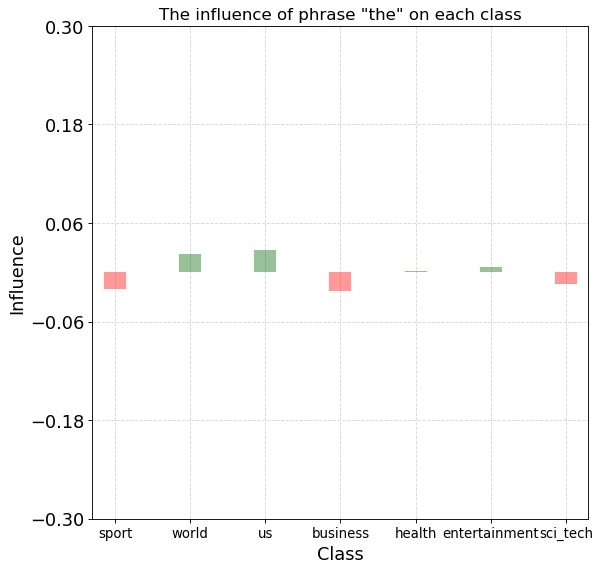

In [15]:
#Plot influence
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='once')

id2class = ["sport", "world", "us", "business", "health", "entertainment", "sci_tech"]

# set the  fontsize and some other elements
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
%matplotlib inline

def plot_influence_word(word):
    class_d = ["sport", "world", "us", "business", "health", "entertainment", "sci_tech"]
    word_goal = word2index(word) # Set your goal word here
    index_d = [0,1,2,3,4,5,6]
    infl_w = influence(word_goal).tolist()
    colors_d = ['red' if x < 0 else 'darkgreen' for x in infl_w]
    # Draw plot
    plt.figure(figsize=(8,8), dpi= 80)
    plt.vlines(x=index_d, ymin=0, ymax=infl_w, color=colors_d, alpha=0.4, linewidth=20)

    # Decorations
    plt.gca().set(xlabel='Class', ylabel='Influence')
    plt.xticks(index_d, class_d, fontsize=12)
    plt.title('The influence of word "'+index2word(word_goal)+'" on each class', fontdict={'size':15})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
    
def plot_influence_word_l(word_l):
    class_d = ["sport", "world", "us", "business", "health", "entertainment", "sci_tech"]
    word_goal = word2index_l(word_l) # Set your goal word here
    index_d = [0,1,2,3,4,5,6]
    infl_w = influence_l(word_goal).tolist()
    colors_d = ['red' if x < 0 else 'darkgreen' for x in infl_w]
    # Draw plot
    plt.figure(figsize=(8,8), dpi= 80)
    plt.vlines(x=index_d, ymin=0, ymax=infl_w, color=colors_d, alpha=0.4, linewidth=20)
    plt.yticks(np.linspace(-0.3,0.3,6))
    # Decorations
    plt.gca().set(xlabel='Class', ylabel='Influence')
    plt.xticks(index_d, class_d, fontsize=12)
    plt.title('The influence of phrase "'+' '.join([index2word(word) for word in word_goal])+'" on each class', fontdict={'size':15})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
    
# Test:
# plot_influence_word_l('caps and pens win in double overtime as wings advance'.split())
plot_influence_word_l('the'.split())

In [10]:
# Glove word embedding
from torchtext.vocab import GloVe
import torch.nn
glove_vectors= GloVe()
# set freeze to false if you want them to be trainable
my_embeddings = torch.nn.Embedding.from_pretrained(glove_vectors.vectors,freeze=True) 

#tensor_to_train = []
#for word in torchtext.vocab.Vocab.get_itos(train_dataset):
#    if word in glove_vectors.itos:
#        tensor_to_train.append(my_embeddings(torch.LongTensor([glove_vectors.stoi[word]]))[0])
#    else:
#        tensor_to_train.append(torch.rand(300))

#w2v_glove = word2vec(tensor_to_train,100,'PCA')
#print(type(w2v_glove[0]))
#np.save('w2v_glove',w2v_glove)        
    

def dist_glove(w1,w2):
    vec_1 = my_embeddings(torch.LongTensor([glove_vectors.stoi[w1]]))
    vec_2 = my_embeddings(torch.LongTensor([glove_vectors.stoi[w2]]))
    return torch.sum((vec_1 - vec_2)**2)/vec_1.numel()

def w2v_on_glove(word_list,color_list):
    word_glove = []
    color_glove = []
    for idx in range(len(word_list)):
        if word_list[idx] in glove_vectors.stoi:
            word_glove.append(word_list[idx])
            color_glove.append(color_list[idx])
    train_set_glove = []
    for i in [glove_vectors.stoi[x] for x in word_glove]:
        for k in range(100):
            train_set_glove.append(i+k) #augmentation
    ind_set_glove = sorted(list(set(train_set_glove)))
    train_set_glove = my_embeddings(torch.LongTensor(sorted(list(set(train_set_glove)))))
    return word2vec(train_set_glove),ind_set_glove

def get_w2v_glove_id(word,ind_set_glove):
    return ind_set_glove.index(glove_vectors.stoi[word])
print(my_embeddings(torch.LongTensor([1])))
# Test
# word_glove_tst = ['bruins', 'knicks', 'celtics', 'sox', 'bulls', 'playoff', 'basketball', 'lakers', 'draft', 'nfl', 'players', 'lockout', 'davis', 'soccer', 'yankees', 'tournament', 'coach', 'djokovic', 'mets', 'cup', 'rangers', 'butler', 'champions', 'canucks', 'dodgers', 'jeter', 'ncaa', 'mavericks', 'cubs', 'nascar', 'phillies', 'playoffs', 'famer', 'tressel', 'roddick', 'dame', 'nhl', 'sports', 'derby', 'roger', 'football', 'sharks', 'rays', 'marlins', 'fifa', 'pitcher', 'mccourt', 'federer', 'pacquiao', 'predators', 'syrian', 'sudan', 'yemen', 'libyan', 'syria', 'pakistan', 'egypt', 'gaddafi', 'mubarak', 'nato', 'lebanon', 'gaza', 'bahrain', 'lede', 'gadhafi', 'qaddafi', 'militants', 'journal', 'pm', 'clashes', 'burkina', 'rebels', 'opposition', 'tunisian', 'peru', 'yemeni', 'dissident', 'somalia', 'egyptians', 'thai', 'ivorian', 'afghans', 'tunisia', 'morocco', 'uae', 'turkey', 'coalition', 'erupts', 'ivory', 'lama', 'belarus', 'libyans', 'extradites', 'swaziland', 'envoys', 'putin', 'defy', 'ecuador', 'county', 'districts', 'wildfire', 'identification', 'layoffs', 'kit', 'cpsc', '1988', 'florida', 'calculations', 'abduction', 'giffords', 'karaoke', 'louisiana', 'california', 'identifying', 'blagojevich', 'demolished', 'graders', 'wisconsin', 'artifacts', '3-day', 'refineries', 'controllers', 'closely', 'idaho', 'firefighters', 'inspections', 'voids', 'balk', 'levee', 'virginia', 'vetoes', '132', 'haze', '141', 'faa', 'suspect', 'mississippi', 'unabomber', 'birther', 'incompetent', 'anthony', 'wildfires', 'fence', 'yellowstone', 'vigilante', 'immigration', 'dollar', 'wall', 'stocks', 'output', 'hybrid', 'inflation', 'hybrids', 'consumer', 'detergent', 'caveats', 'bribed', 'deceived', 'contraction', 'deflate', 'securities', 'banks', 'chrysler', 'cvs', 'liquidity', 'thrifty', 'discoveries', 'citadel', 'shoppers', 'ihs', 'auctions', 'woo', 'volatile', 'cftc', 'q1', 'mortgage', 'disruptions', 'cursing', 'qe2', 'dumping', 'buying', 'indexes', 'tarp', 'hedge', 'sharply', 'onion', 'quesadillas', 'beet', 'carrots', 'breadsticks', 'goat', 'patients', 'disease', 'frittata', 'inhaler', 'spinach', 'sprouted', 'crackers', 'tuberculosis', 'leeks', 'leisurely', 'asthma', 'chickpeas', 'fractures', 'adhd', 'treatments', 'exercising', 'cancer', 'coconut', 'exercise', 'chard', 'vitamin', 'obesity', 'epidemic', 'garlic', 'chugging', 'bedbug', 'type', 'bulgur', 'vaccine', 'vitamins', 'flashes', 'wheat', 'dog', 'prescriptions', 'clot', 'intake', 'culls', 'lucentis', 'fade', 'genes', 'healthcare', 'hoarders', 'contaminants', 'depict', 'jovi', 'bossypants', 'gabor', 'airplay', 'bunnies', 'idol', 'eddie', 'lobbyist', 'macdowell', 'khalifa', 'dawn', 'snl', 'anymore', 'gosselin', 'diana', 'grisham', '80s', 'hetherington', 'cannes', 'premiere', 'spears', 'holmes', 'villain', 'goodwin', 'bengal', 'gig', 'abrams', 'fringe', 'kutcher', 'theater', 'dwts', 'hefner', 'fatale', 'edinburgh', 'insidious', 'beatrice', 'egan', 'larsson', 'beasties', 'britney', 'bon', 'arness', 'anatomy', 'middleton', 'arthur', 'dogg', 'franklin', 'automatically', 'macaques', '3ds', 'conferencing', 'gamepad', 'chrome', 'software', '+', 'borealis', 'lcd', 'aurora', 'psn', 'covets', 'universe', 'mobile', 'agee', 'playstation', 'console', 'outage', 'apple', 'windows', 'nortel', 'gmail', 'miramax', 'climate', 'labels', 'radar', 'gagarin', 'malware', 'icloud', 'interface', 'google', 'computing', 'tablets', 'facebook', 'location', 'spectrum', 'roaming', 'photoshop', 'ie', 'gadgets', 'kart', 'ipad', 'merge', 'pandora', 'appstore', 'ericsson', 'companion', 'button']
# color_glove_tst = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']
# w2v_glove,w2v_ind_set_glove = w2v_on_glove(word_glove_tst,color_glove_tst)

tensor([[ 0.0120,  0.2075, -0.1258, -0.5932,  0.1252,  0.1597,  0.1375, -0.3316,
         -0.1369,  1.7893, -0.4709,  0.7043,  0.2667, -0.0900, -0.1817,  0.0672,
          0.0533,  1.5595, -0.2541,  0.0384, -0.0141,  0.0568,  0.0234,  0.0240,
          0.3170,  0.1902, -0.3751,  0.0356,  0.1181,  0.0120, -0.0376, -0.5046,
         -0.0493,  0.0924,  0.1103, -0.0731,  0.3399,  0.2824,  0.1341,  0.0701,
         -0.0221, -0.2810,  0.4961, -0.4869, -0.0910, -0.1538, -0.3801, -0.0142,
         -0.1939, -0.1107, -0.0141, -0.1791,  0.2451, -0.1688, -0.1535, -0.1381,
          0.0215,  0.1370,  0.0068, -0.1491, -0.3817,  0.1273,  0.4401,  0.3268,
         -0.4612,  0.0687,  0.3475,  0.1883, -0.3184,  0.4447, -0.2095, -0.2699,
          0.4895,  0.1539,  0.0529, -0.0498,  0.1121,  0.1488, -0.3700,  0.3078,
         -0.3386,  0.0451, -0.1899,  0.2663, -0.2640, -0.4756,  0.6838, -0.3065,
          0.2461,  0.3161, -0.0711,  0.0304,  0.0881,  0.0450,  0.2013, -0.2162,
         -0.3637, -0.2595, -

In [9]:
#Plot visualized word2vec
def plot_w2v(word_id_list,color_list,word2vec = w2v):
    x_w = []
    y_w = []
    for word in word_id_list:
        x_w.append(word2vec[word].tolist()[0])
        y_w.append(word2vec[word].tolist()[1])
    plt.scatter(x_w, y_w, c = color_list)
    plt.show()
    
# Test:
# plot_w2v([word2index(x) for x in word_glove_tst],color_glove_tst)
# plot_w2v([get_w2v_glove_id(x,w2v_ind_set_glove) for x in word_glove_tst],color_glove_tst,w2v_glove)

In [19]:
# diff_word(word2index('basketball'),word2index('nfl')) 0.011
# dist_glove('basketball','abs') 0.1
def find_pair(word_list,vocabulary = torchtext.vocab.Vocab.get_itos(train_dataset),eps = 0.01,delta = 0.1,mode = 'adversarial'): # or 'collaborative'
    out = []
    flag = True
    if (mode == 'adversarial'):
        for w_adv in word_list:
            flag = False
            w_out = 'Failed for searching!'
            if w_adv not in glove_vectors.itos:
                flag = False
                continue
            dist = -1e9
            cur_dist = 0
            for w in vocabulary:
                if (w != w_adv) and (w in glove_vectors.itos) and (dist_glove(w,w_adv) <= delta):
                    cur_dist = diff_word(word2index(w_adv),word2index(w))
                    if (cur_dist >= dist):# and (cur_dist >= eps):
                        w_out = w
                        dist = cur_dist
                        flag = True
            out.append((w_adv,w_out))
    elif (mode == 'collaborative'):
        for w_adv in word_list:
            w_out = 'Failed for searching!'
            dist = cur_dist = -1e9
            for w in vocabulary:
                if (w != w_adv) and (w in glove_vectors.itos) and (w_adv in glove_vectors.itos) and (diff_word(word2index(w_adv),word2index(w)) <= eps):
                    cur_dist = dist_glove(w,w_adv)
                    if (cur_dist >= dist):# and (cur_dist >= delta):
                        w_out = w
                        dist = cur_dist
            out.append((w_adv,w_out))
    if flag:
        return out
    return False

# Test:
#test_wl = [ 'basketball', 'lakers', 'draft', 'nfl' , 'pakistan', 'egypt', 'county', 'districts', 'wildfire', 'layoffs', 'hybrid', 'inflation', 'consumer', 'exercise', 'vitamin', 'obesity','abrams', 'theater', 'dwts','apple', 'windows', 'gmail', 'climate',]
#test_wl = ['nfl']
#print(find_pair(test_wl,eps = 0.01 , delta = 0.1, vocabulary = torchtext.vocab.Vocab.get_itos(train_dataset)[:2000]))
#print(find_pair(test_wl,eps = 0.012 , delta = 0.1, vocabulary = torchtext.vocab.Vocab.get_itos(train_dataset)[:2000],mode = 'collaborative'))

In [23]:
def seq_pred(seq):
    seq_list = seq.split()
    for word in range(len(seq_list)):
        if seq_list[word] not in torchtext.vocab.Vocab.get_itos(train_dataset):
            seq_list[word] = '<unk>'
    out = model(torch.tensor([[word2index(x)] for x in seq_list]).to('cuda:0'))[0].tolist()
    return id2class[out.index(max(out))]

def replace_adv_seq(seq,word_num = 1,mode = 'adv'):
    seq_list = seq.split()
    flag = True
    for word in range(len(seq_list)):
        if seq_list[word] not in torchtext.vocab.Vocab.get_itos(train_dataset):
            seq_list[word] = '<unk>'
    norm_list = [np.linalg.norm(influence(word2index(word)).cpu()) for word in seq_list]
    index_set = heapq.nlargest(word_num, range(len(norm_list)), norm_list.__getitem__)
    #print(word_to_replace,norm_list)
    #index_set = [norm_list.index(word) for word in word_to_replace]
    if mode == 'glove':
        for index in index_set:
            seq_list[index] = get_nearest_w2v(seq_list[index])
        return ' '.join(seq_list)
    for index in index_set:
        seq_list[index] = find_pair([seq_list[index]], eps = 0.01 , delta = 0.18, vocabulary = torchtext.vocab.Vocab.get_itos(train_dataset)[:2000])
        if seq_list[index] != False:
            seq_list[index] = seq_list[index][0][1]
        if seq_list[index] == False:
            return False
    return ' '.join(seq_list) 

# Test
#seq = 'eye-opener: are the heat now the favorites in the east?'
#seq_replaced = replace_adv_seq(seq,1)
#print('replaced seq:',seq_replaced)
#print('initial category:',seq_pred(seq))
#print('now category:',seq_pred(seq_replaced))
acc_counter = 0
all_counter = 0
for seq in test_list:
    seq_replaced = replace_adv_seq(seq,1)
    if seq_replaced == False:
        continue
    pred_0 = seq_pred(seq)
    pred_1 = seq_pred(seq_replaced)
    all_counter += 1
    if pred_0 != pred_1:
        acc_counter += 1
        print('original seq:',seq)
        print('replaced seq:',seq_replaced)
        print('initial category:',seq_pred(seq))
        print('now category:',seq_pred(seq_replaced))
        print(acc_counter,'instance found.')
print(acc_counter / all_counter)

original seq: the forces that can change fifa
replaced seq: the forces that can change playstation
initial category: sport
now category: world
1 instance found.
original seq: questions about the bracket and beyond
replaced seq: questions about the box and beyond
initial category: sport
now category: entertainment
2 instance found.
original seq: africa has record entry for 2014 world cup
replaced seq: africa has record entry for 2014 world fresh
initial category: sport
now category: world
3 instance found.
original seq: ryan breymaier chronicles sailing race around the world
replaced seq: ryan <unk> war sailing race around the world
initial category: sport
now category: us
4 instance found.
original seq: lightning, bruins ready for business after long layoff
replaced seq: <unk> stanley ready for business after long layoff
initial category: sport
now category: business
5 instance found.
original seq: spain's socialists punished in local elections
replaced seq: <unk> democrats punished in

0.4489795918367347


In [8]:
import csv
test_list = []
counter = 0
with open('./test_data_pytorch.csv','r') as f:
    rete = csv.reader(f)        
    for x in rete:
        if counter == 15 and x[-1] == cate:
            continue+
        if counter == 15 and x[-1] != cate:
            counter = 0
        cate = x[-1]
        test_list.append(x[1])
        counter += 1
def find_phrase(len_p = 2,fl = 20, state = 0):
    w_l = ['players', 'nfl', 'lockout', 'knicks', 'soccer', 'rangers', 'bulls', 'cup', 'basketball', 'mets', 'sox', 'celtics', 'bruins', 'coach', 'draft', 'ncaa', 'djokovic', 'pitcher', 'yankees', 'replay', 'football', 'butler', 'mavericks', 'champions', 'tressel', 'sports', 'espn', 'jeter', 'lakers', 'tournament', 'trophy', 'dodgers', 'roddick', 'nowitzki', 'braves', 'federer', 'phillies', 'davis', 'derby', 'tourney', 'dame', 'sharapova', 'pacquiao', 'wade', 'nascar', 'roger', 'preview', 'bryant', 'posada', 'seconds', 'canucks', 'marlins', 'killebrew', 'title', 'augusta', 'grizzlies', 'opener', 'olympics', 'nhl', 'hamilton', 'fifa', 'championship', 'richmond', 'dickey', 'cubs', 'blackhawks', 'uconn', 'playoffs', 'homers', 'reds', 'mcdowell', 'clijsters', 'miller', 'newton', 'messi', 'purdue', '76ers', 'hornets', 'ot', 'worlds', 'biscayne', 'predators', 'cardinals', 'blazers', 'palmer', 'earns', 'elbow', 'orioles', 'schiavone', 'no-hitter', 'mccourt', 'jays', 'inning', 'manny', 'irving', 'athletics', 'wozniacki', '2-0', 'rookie', 'games']
    p_id = 'failed to fetch','failed to fetch'
    ind = -1e2
    for i in w_l:
        for j in w_l:
            ind_ij = influence_l([word2index(i),word2index(j)])[state] - 2*influence(word2index(i))[state] - 2*influence(word2index(j))[state]
            if ind_ij > ind:
                ind = ind_ij
                p_id = i,j
    return p_id
    
# Test
# find_phrase()
print(len(test_list))

105


In [20]:
seq = 'real captain <unk> drops king cups under a bus nfl nfl nfl nfl'.split()
print(seq)
print([word2index(x) for x in seq])
to_pred = [[word2index(x)] for x in seq]
while True:
    if len(to_pred) == 25:
        break
    to_pred.append([0])
print(to_pred)
print(model(torch.tensor(to_pred).to('cuda:0')))

['real', 'captain', '<unk>', 'drops', 'king', 'cups', 'under', 'a', 'bus', 'nfl', 'nfl', 'nfl', 'nfl']
[434, 2201, 0, 761, 988, 2970, 331, 10, 590, 62, 62, 62, 62]
[[434], [2201], [0], [761], [988], [2970], [331], [10], [590], [62], [62], [62], [62], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
tensor([[ 8.9377, -8.2346, -1.7621, -3.5665, -4.0292, -3.3785, -2.6304]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
